In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-preprocessed/hindi_preprocessed_2.csv


# Import Data, Splitting Data, Tokenization

In [91]:
df = pd.read_csv('/kaggle/input/hindi-preprocessed/hindi_preprocessed_2.csv')
print(df.head())

                                                text  task_1
0   dying        liars i warned  yrs back  banned...       1
1  सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...       1
2  शेरए सिवान शहाबुद्दीन साहब से रिश्ता क्या لا إ...       1
3                     आसमानी किताब के नाजायज औलाद है       0
4  इसे कहते हैं दोगला पंती जिस सपा की दम पर  से  ...       1


**Install Transformer**

In [92]:
# install transformers
!pip install "transformers ==4.16.2"
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [93]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [94]:
#rename columns
df = df.rename(columns={'tweet': 'text','task_1' : 'label'})

In [95]:
# print first text
df.text.values[0]

' dying        liars i warned  yrs back  banned by sardar patel ignored ेरनहींभेड़ियापाललियाभक्तो '

In [96]:
# print tokens of first text
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df.text.values[0].split()})

{'dying': [2160, 214], 'liars': [400, 21816], 'i': [17], 'warned': [1631, 14534], 'yrs': [2938, 7], 'back': [4420], 'banned': [4599, 14534], 'by': [390], 'sardar': [10649, 1506], 'patel': [249, 1708], 'ignored': [124962, 71], 'ेरनहींभेड़ियापाललियाभक्तो': [6, 7875, 998, 3054, 838, 65758, 12372, 11635, 41590, 105755, 146677, 2284]}


In [97]:
#drop null values
df = df.dropna()

**Finding Max length of tokenized sentence**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


max:  355
min:  3


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000')])

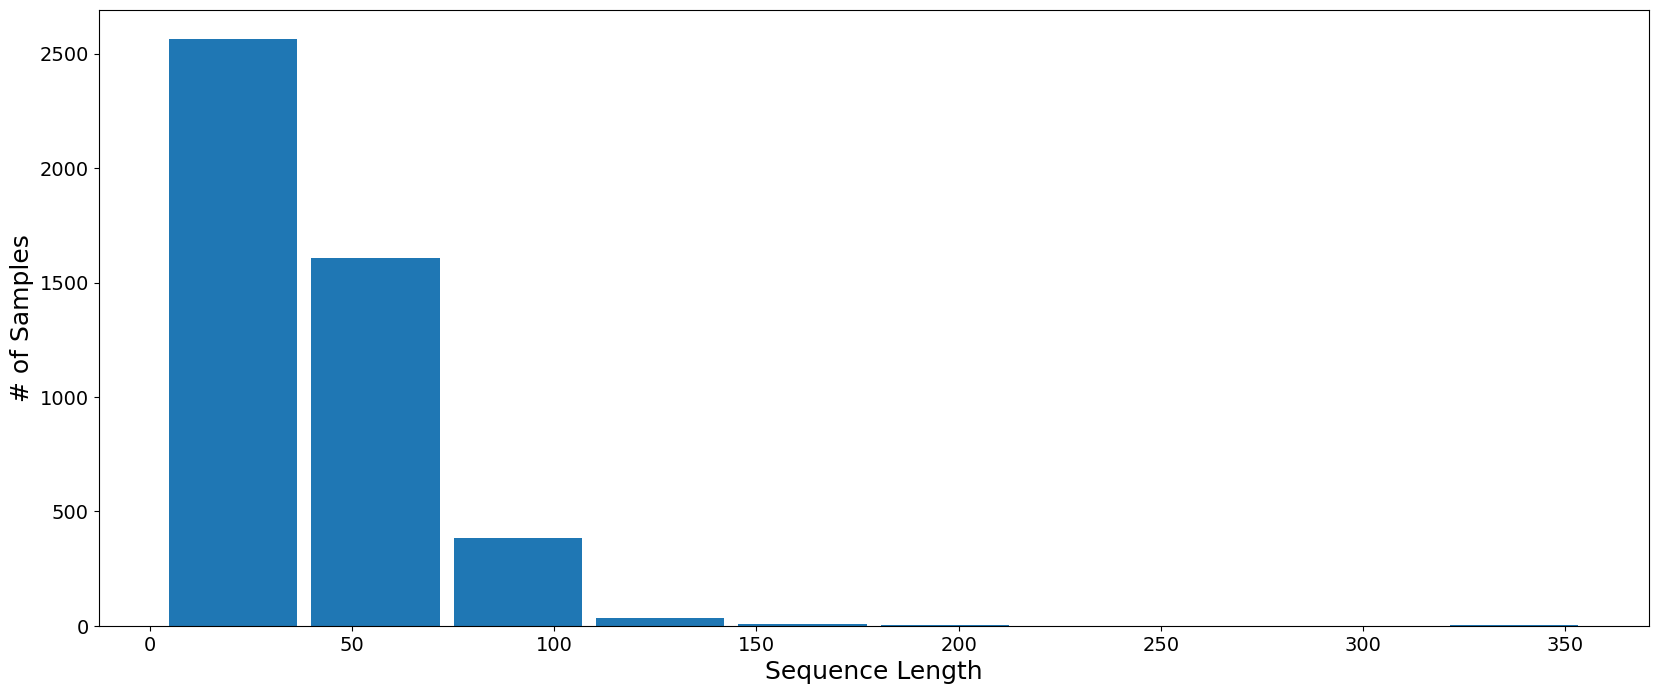

In [98]:
# install matplotlib
!pip install matplotlib
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            df.text.values.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

**Identify Features and target**

In [99]:
# identify features and target
features = df.text.values.tolist()
target = df.label.values.tolist()

**Tokenize Features**

In [100]:
# tokenize features
MAX_LEN = 150
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features,
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN,
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'
                   )

In [101]:
print(tokenized_feature)

{'input_ids': tensor([[     0,   2160,    214,  ...,      1,      1,      1],
        [     0,  15699,  19181,  ...,      1,      1,      1],
        [     0, 164860,   6690,  ...,      1,      1,      1],
        ...,
        [     0,      6,   3558,  ...,      1,      1,      1],
        [     0,  10903,  36733,  ...,      1,      1,      1],
        [     0,  55423,    287,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


**Train Test Split**

In [102]:
from sklearn.model_selection import train_test_split

# First, split the data into training and the rest
train_inputs, rest_inputs, train_labels, rest_labels, train_masks, rest_masks = train_test_split(tokenized_feature['input_ids'],
                                                                                                target,
                                                                                                tokenized_feature['attention_mask'],
                                                                                                random_state=2000,
                                                                                                test_size=0.2,
                                                                                                stratify=target)

# Then, split the rest into validation and testing
validation_inputs, test_inputs, validation_labels, test_labels, validation_masks, test_masks = train_test_split(rest_inputs,
                                                                                                                  rest_labels,
                                                                                                                  rest_masks,
                                                                                                                  random_state=2000,
                                                                                                                  test_size=0.5,
                                                                                                                stratify=rest_labels)
                               

In [103]:
len(validation_inputs)

459

In [104]:
train_inputs.shape

torch.Size([3675, 150])

# Create Dataloaders

In [105]:
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Define XMLR Pretrained model

In [106]:

from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    # Specify number of classes
    num_labels = len(set(target)),
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states
    output_hidden_states = False
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

**Define Optimizer**

In [107]:
# Optimizer 
optimizer = AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8,
                  weight_decay=0.01
                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Define Scheduler and epochs**

In [108]:
# Number of training epochs
epochs = 5
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 5,
                                            num_training_steps = total_steps)

In [109]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')


Using GPU: Tesla T4


In [110]:
#move model to device
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [111]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [112]:
#set seeds to control randomness
import numpy as np
import random

seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training and Validation Phase

In [113]:
from sklearn.metrics import classification_report

train_losses= []
val_losses=[]

for n in range(epochs):
    # List to store predictions and ground truth labels for both training and validation sets
    train_preds = []
    train_labels_all = []
    val_preds = []
    val_labels_all = []

    train_loss = 0
    val_loss = 0
    start_time = time.time()
    
    # Calculate number of mini-batches for training and validation sets
    num_mb_train = len(train_dataloader)
    num_mb_val = len(validation_dataloader)

    # Training phase
    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()

        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.data / num_mb_train

        # Append predictions and labels
        train_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
        train_labels_all += mb_y.cpu().tolist()

    # Validation phase
    with torch.no_grad():
        model.eval()

        for k, (mb_x, mb_m, mb_y) in enumerate(validation_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)

            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            loss = outputs[0]
            val_loss += loss.data / num_mb_val

            # Append predictions and labels
            val_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
            val_labels_all += mb_y.cpu().tolist()

    # Compute metrics
    train_report = classification_report(train_labels_all, train_preds, target_names=['NOT', 'HOF'])
    val_report = classification_report(val_labels_all, val_preds, target_names=['NOT', 'HOF'])

    print(f'Training report after iteration {n+1}:\n{train_report}')
    print(f'Validation report after iteration {n+1}:\n{val_report}')

    train_losses.append(train_loss.cpu())
    val_losses.append(val_loss.cpu())

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Training report after iteration 1:
              precision    recall  f1-score   support

         NOT       0.54      0.05      0.09      1146
         HOF       0.69      0.98      0.81      2529

    accuracy                           0.69      3675
   macro avg       0.62      0.52      0.45      3675
weighted avg       0.65      0.69      0.59      3675

Validation report after iteration 1:
              precision    recall  f1-score   support

         NOT       0.77      0.29      0.42       143
         HOF       0.75      0.96      0.84       316

    accuracy                           0.75       459
   macro avg       0.76      0.62      0.63       459
weighted avg       0.76      0.75      0.71       459

Time: 1.0m 54.6457302570343s
Training report after iteration 2:
              precision    recall  f1-score   support

         NOT       0.66      0.43      0.52      1146
         HOF       0.78      0.90      0.83      2529

    accuracy                           0.75   

In [114]:
print(train_losses)

[tensor(0.6061), tensor(0.5056), tensor(0.4360), tensor(0.3816), tensor(0.3344)]


In [115]:
print(val_losses)

[tensor(0.4757), tensor(0.4304), tensor(0.4353), tensor(0.4734), tensor(0.4911)]


# Testing Phase

In [116]:
# Testing 
model.eval()
test_preds = []
test_labels_all = []

with torch.no_grad():
    for mb_x, mb_m, mb_y in test_dataloader:
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        test_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
        test_labels_all += mb_y.cpu().tolist()

# Compute and print classification report for testing
test_report = classification_report(test_labels_all, test_preds, target_names=['NOT', 'HOF'])
print(f'Testing report:\n{test_report}')

Testing report:
              precision    recall  f1-score   support

         NOT       0.70      0.65      0.67       144
         HOF       0.84      0.88      0.86       316

    accuracy                           0.80       460
   macro avg       0.77      0.76      0.77       460
weighted avg       0.80      0.80      0.80       460



**F1 score**

In [124]:
from sklearn.metrics import f1_score

# Assuming test_labels_all and test_preds are your true labels and predicted labels respectively
macro_f1 = f1_score(test_labels_all, test_preds, average='weighted')
print("F1 Score:", macro_f1)


F1 Score: 0.8019173642992168


**Confusion Matrix of test data**

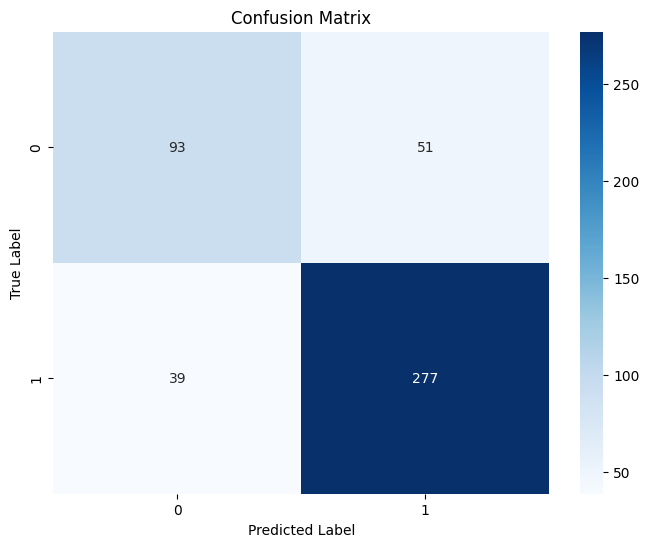

In [122]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(test_labels_all, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Testing on provided input

In [123]:
# Define your input sentence
sentence ="बिल्कुल सत्य ऐसे गद्दारों ने ही देश को बर्बाद कर दिया"
# Tokenize input sentence
encoding = tokenizer(sentence, return_tensors="pt")

# Move input tensors to the same device as the model
encoding = {k: v.to(device) for k, v in encoding.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**encoding)

# Get predicted logits
logits = outputs[0]

# Get predicted class index (index with the highest probability)
predicted_class_index = logits.argmax(-1).item()

# Print predicted class index
print("Predicted class index:", predicted_class_index)

Predicted class index: 0
